ML Final Project

Spring 2017 - NYU CUSP

Notebook reads in datetime converted CitiBike Data by month (e.g. Jan_citi.csv) from 2016 and converts gets the counts and means per month

Written in Python 2.7 (Anaconda)

In [2]:
import numpy as np
import pandas as pd
import geopandas as gp
from geopandas import GeoDataFrame
import os
from shapely.geometry import Point
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import roc_auc_score as rs
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import IsolationForest
from pandas.tseries.holiday import USFederalHolidayCalendar
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(222)

%matplotlib inline
%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

Populating the interactive namespace from numpy and matplotlib


/home/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
proj_folder = os.getcwd()
proj_folder

'/wingrdp/homedirs/gtp232/machine_learning/anomaly_detection_NYC_transit'

Check for spurious entires

## Remove spurious trip length rationale

From website: A $101 security deposit hold will be placed on your card when you purchase a pass. If you incur usage

fees, your card will be charged. The fee for a lost or stolen bike is $1200 (+ tax).


## Total Loss: 

Annual pass = 163/year + 101 Security fee + ($ 2.50 * min) = 5616 minutes
 
3 day Pass = 24 + 101 Security fee + ($ 2.50 * 15min) = 4031.25

Day Pass = 12 + 101 Security fee + ($4 * 15min) = 4076.25

Ride = 4 + 101 Security fee + ($4 * 15min) = 4106.25 

So remove anything longer than 5616 minutes, the maximum time before Total Loss and keep trip long than 1 minute

## Aggregate by day and Export

In [5]:
columns =['bike_date', 'tripduration', 'start station id', 'start station latitude', 'start station longitude', \
          'end station id', 'end station latitude','end station longitude', 'bikeid', 'birth year', \
          'gender', 'start_hour', 'end_hour','bike_trip_count']

In [6]:
months = ["Jan_citi", "Feb_citi", "Mar_citi", "Apr_citi", "May_citi", "Jun_citi", "Jul_citi", "Aug_citi", \
          "Sep_citi", "Oct_citi", "Nov_citi", "Dec_citi"]

In [7]:
months2 = ["citibike_201501", "citibike_201502", "citibike_201503", "citibike_201504", "citibike_201505", \
          "citibike_201506", "citibike_201507", "citibike_201508", "citibike_201509", "citibike_201510", \
          "citibike_201511", "citibike_201512"]

In [8]:
# Create Empty dataframe
citi_df_all_day = pd.DataFrame(columns=columns)

,bike_date,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,start_hour,end_hour,bike_trip_count


In [10]:
for i in (months2):
    print i
    df = pd.read_csv('data/' + i + '.csv')
    
    #change seconds to minutes
    df['tripduration'] = df['tripduration'].apply(lambda x: x / 60)
    #Remove spurious trips
    df = df[(df.tripduration > 1) & (df.tripduration < 5616)]
    #DatTime again??
    df['starttime'] = pd.to_datetime(df['starttime'])
    df['stoptime'] = pd.to_datetime(df['stoptime'])
    #citi_agg['day_number'] = label.starttime.apply(lambda x: x.hour)
    df['bike_date'] = df['starttime'].dt.date
    
    
    #Count Trips per day 
    
    citi_df_all_day = citi_df_all_day.append(df, ignore_index = True)

citibike_201501
citibike_201502
citibike_201503
citibike_201504
citibike_201505
citibike_201506
citibike_201507
citibike_201508
citibike_201509
citibike_201510
citibike_201511
citibike_201512


In [11]:
citi_df_all_day.head()

,bike_date,bike_trip_count,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,end_hour,gender,start station id,start station latitude,start station longitude,start station name,start_hour,starttime,stoptime,tripduration,usertype
0,2015-01-01,NaN,18660.0,1960.0,265.0,40.722293,-73.991475,Stanton St & Chrystie St,NaN,2.0,455.0,40.750020,-73.969053,1 Ave & E 44 St,NaN,2015-01-01 00:01:00,2015-01-01 00:24:00,22.0,Subscriber
1,2015-01-01,NaN,16085.0,1963.0,482.0,40.739355,-73.999318,W 15 St & 7 Ave,NaN,1.0,434.0,40.743174,-74.003664,9 Ave & W 18 St,NaN,2015-01-01 00:02:00,2015-01-01 00:08:00,6.0,Subscriber
2,2015-01-01,NaN,20845.0,1974.0,505.0,40.749013,-73.988484,6 Ave & W 33 St,NaN,1.0,491.0,40.740964,-73.986022,E 24 St & Park Ave S,NaN,2015-01-01 00:04:00,2015-01-01 00:10:00,5.0,Subscriber
3,2015-01-01,NaN,19610.0,1969.0,399.0,40.688515,-73.964763,Lafayette Ave & St James Pl,NaN,1.0,384.0,40.683178,-73.965964,Fulton St & Waverly Ave,NaN,2015-01-01 00:04:00,2015-01-01 00:07:00,3.0,Subscriber
4,2015-01-01,NaN,20197.0,1977.0,432.0,40.726218,-73.983799,E 7 St & Avenue A,NaN,1.0,474.0,40.745168,-73.986831,5 Ave & E 29 St,NaN,2015-01-01 00:05:00,2015-01-01 00:21:00,16.0,Subscriber


### Add holiday / day of week / weekend features

In [12]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016', return_name=True)
holidays.name = 'name'
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Dr. Martin Luther King Jr.
2012-02-20                Presidents Day
2012-05-28                   MemorialDay
2012-07-04                      July 4th
Name: name, dtype: object

In [13]:
holidays_all = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()

In [14]:
citi_df_all_day['bike_date'] = pd.to_datetime(citi_df_all_day['bike_date'])

In [15]:
#add holiday dummy variable
citi_df_all_day['holiday'] = 0
citi_df_all_day['holiday'][citi_df_all_day['bike_date'].isin(holidays_all.index.date)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
citi_df_all_day['day_of_week'] = citi_df_all_day.bike_date.apply(lambda x: x.weekday())

In [17]:
#control for Friday / Saturday nights
citi_df_all_day['weekend'] = 0
citi_df_all_day['weekend'][(citi_df_all_day['day_of_week'] == 4) | (citi_df_all_day['day_of_week'] == 5)] = 1

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Grouping by station and day

In [18]:
citi_df_all_day_mean = citi_df_all_day.groupby(['bike_date', 'holiday', 'weekend', 'start station id', 'start station latitude', 'start station longitude'], as_index=False)['tripduration'].mean()
citi_df_all_day_mean.head()

,bike_date,holiday,weekend,start station id,start station latitude,start station longitude,tripduration
0,2015-01-01,1,0,72.0,40.767272,-73.993929,17.100000
1,2015-01-01,1,0,79.0,40.719116,-74.006667,14.133333
2,2015-01-01,1,0,82.0,40.711174,-74.000165,9.333333
3,2015-01-01,1,0,83.0,40.683826,-73.976323,7.428571
4,2015-01-01,1,0,116.0,40.741776,-74.001497,13.307692


In [19]:
citi_df_all_day_count = citi_df_all_day.groupby(['bike_date', 'holiday', 'weekend', 'start station id', 'start station latitude', 'start station longitude'], as_index=False)['bikeid'].count()
citi_df_all_day_count.head()

,bike_date,holiday,weekend,start station id,start station latitude,start station longitude,bikeid
0,2015-01-01,1,0,72.0,40.767272,-73.993929,10
1,2015-01-01,1,0,79.0,40.719116,-74.006667,15
2,2015-01-01,1,0,82.0,40.711174,-74.000165,9
3,2015-01-01,1,0,83.0,40.683826,-73.976323,7
4,2015-01-01,1,0,116.0,40.741776,-74.001497,26


In [20]:
citi_df_all_day_agg = citi_df_all_day_count.merge(citi_df_all_day_mean)
citi_df_all_day_agg.head()

,bike_date,holiday,weekend,start station id,start station latitude,start station longitude,bikeid,tripduration
0,2015-01-01,1,0,72.0,40.767272,-73.993929,10,17.100000
1,2015-01-01,1,0,79.0,40.719116,-74.006667,15,14.133333
2,2015-01-01,1,0,82.0,40.711174,-74.000165,9,9.333333
3,2015-01-01,1,0,83.0,40.683826,-73.976323,7,7.428571
4,2015-01-01,1,0,116.0,40.741776,-74.001497,26,13.307692


In [21]:
citi_df_all_day_agg.columns = ['bike_date', 'holiday', 'weekend', 'start_station_id', 'start station latitude',\
                              'start station longitude', 'bike_trip_count', 'tripduration']
citi_df_all_day_agg.head()

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration
0,2015-01-01,1,0,72.0,40.767272,-73.993929,10,17.100000
1,2015-01-01,1,0,79.0,40.719116,-74.006667,15,14.133333
2,2015-01-01,1,0,82.0,40.711174,-74.000165,9,9.333333
3,2015-01-01,1,0,83.0,40.683826,-73.976323,7,7.428571
4,2015-01-01,1,0,116.0,40.741776,-74.001497,26,13.307692


## Grouping by day

In [22]:
citi_df_day_mean = citi_df_all_day.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['tripduration'].mean()
citi_df_day_mean.head()

,bike_date,holiday,weekend,tripduration
0,2015-01-01,1,0,13.061735
1,2015-01-02,1,1,11.813467
2,2015-01-03,0,1,10.559855
3,2015-01-04,0,0,10.936526
4,2015-01-05,0,0,10.245255


In [23]:
citi_df_day_count = citi_df_all_day.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['bikeid'].count()
citi_df_day_count.head()

,bike_date,holiday,weekend,bikeid
0,2015-01-01,1,0,5232
1,2015-01-02,1,1,11183
2,2015-01-03,0,1,4419
3,2015-01-04,0,0,7767
4,2015-01-05,0,0,14332


In [24]:
citi_df_day_agg = citi_df_day_count.merge(citi_df_day_mean)
citi_df_day_agg.head()

,bike_date,holiday,weekend,bikeid,tripduration
0,2015-01-01,1,0,5232,13.061735
1,2015-01-02,1,1,11183,11.813467
2,2015-01-03,0,1,4419,10.559855
3,2015-01-04,0,0,7767,10.936526
4,2015-01-05,0,0,14332,10.245255


In [25]:
citi_df_day_agg.columns = ['bike_date', 'holiday', 'weekend', 'bike_trip_count', 'tripduration']
citi_df_day_agg.head()

,bike_date,holiday,weekend,bike_trip_count,tripduration
0,2015-01-01,1,0,5232,13.061735
1,2015-01-02,1,1,11183,11.813467
2,2015-01-03,0,1,4419,10.559855
3,2015-01-04,0,0,7767,10.936526
4,2015-01-05,0,0,14332,10.245255


## Clustering Anomaly Detection

### K-means Anomaly Detection

In [26]:
cluster_features = ['bike_trip_count', 'tripduration', 'holiday', 'weekend']

In [27]:
X = citi_df_day_agg[cluster_features]
X.head(2)

,bike_trip_count,tripduration,holiday,weekend
0,5232,13.061735,1,0
1,11183,11.813467,1,1


In [28]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()
    
X.head()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,bike_trip_count,tripduration,holiday,weekend
0,-1.626679,-0.460979,3.337076,-0.630377
1,-1.180955,-0.867642,3.337076,1.582005
2,-1.687572,-1.276046,-0.298843,1.582005
3,-1.436810,-1.153334,-0.298843,-0.630377
4,-0.945098,-1.378537,-0.298843,-0.630377


In [29]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.333670988682
For n_clusters =3, the average silhouette_score is :0.391073718408
For n_clusters =4, the average silhouette_score is :0.475596725822
For n_clusters =5, the average silhouette_score is :0.512486044108
For n_clusters =6, the average silhouette_score is :0.525734360304
For n_clusters =7, the average silhouette_score is :0.530004287399
For n_clusters =8, the average silhouette_score is :0.536582976357


In [30]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [31]:
citi_df_day_agg['cluster'] = res.cluster
citi_df_day_agg['km_score'] = res.score
citi_df_day_agg['outlier'] = 0
citi_df_day_agg.sort_values("km_score",ascending=False, inplace=True)

In [32]:
citi_df_day_agg.head(10)

,bike_date,holiday,weekend,bike_trip_count,tripduration,cluster,km_score,outlier
358,2015-12-25,1,1,12188,30.319905,0,5.019717,0
45,2015-02-15,1,0,2542,9.134540,0,2.784692,0
46,2015-02-16,1,0,3930,9.587277,0,2.606726,0
220,2015-08-09,0,0,32395,22.888563,4,2.508555,0
1,2015-01-02,1,1,11183,11.813467,0,2.429584,0
283,2015-10-11,1,0,38592,22.411018,0,2.394888,0
184,2015-07-04,1,1,21503,20.964610,0,2.374043,0
47,2015-02-17,1,0,4746,10.410029,0,2.356606,0
329,2015-11-26,1,0,13106,22.674729,0,2.305605,0
359,2015-12-26,1,1,13709,19.987818,0,2.283828,0


In [33]:
citi_df_day_agg['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    elif (Data1.cluster == 2):
        return "purple"
    elif (Data1.cluster == 3):
        return "yellow"
    else:
        return "green"

citi_df_day_agg = citi_df_day_agg.assign(color=citi_df_day_agg.apply(set_color, axis=1))

In [35]:
citi_df_day_agg_w_z_scores = citi_df_day_agg.merge(X, left_index=True, right_index=True)

In [36]:
citi_df_day_agg_w_z_scores.sort_values("km_score",ascending=False, inplace=True)
citi_df_day_agg_w_z_scores[['bike_date', 'km_score',  'bike_trip_count_x',\
                          'tripduration_x', 'holiday_x', 'weekend_x', \
                                    'bike_trip_count_y', 'tripduration_y', 'holiday_y', 'weekend_y']].head(15)

,bike_date,km_score,bike_trip_count_x,tripduration_x,holiday_x,weekend_x,bike_trip_count_y,tripduration_y,holiday_y,weekend_y
358,2015-12-25,5.019717,12188,30.319905,1,1,-1.105681,5.161421,3.337076,1.582005
45,2015-02-15,2.784692,2542,9.134540,1,0,-1.828157,-1.740388,3.337076,-0.630377
46,2015-02-16,2.606726,3930,9.587277,1,0,-1.724198,-1.592895,3.337076,-0.630377
220,2015-08-09,2.508555,32395,22.888563,0,0,0.407804,2.740424,-0.298843,-0.630377
1,2015-01-02,2.429584,11183,11.813467,1,1,-1.180955,-0.867642,3.337076,1.582005
283,2015-10-11,2.394888,38592,22.411018,1,0,0.871953,2.584848,3.337076,-0.630377
184,2015-07-04,2.374043,21503,20.964610,1,1,-0.407996,2.113635,3.337076,1.582005
47,2015-02-17,2.356606,4746,10.410029,1,0,-1.663080,-1.324857,3.337076,-0.630377
329,2015-11-26,2.305605,13106,22.674729,1,0,-1.036924,2.670761,3.337076,-0.630377
359,2015-12-26,2.283828,13709,19.987818,1,1,-0.991760,1.795414,3.337076,1.582005


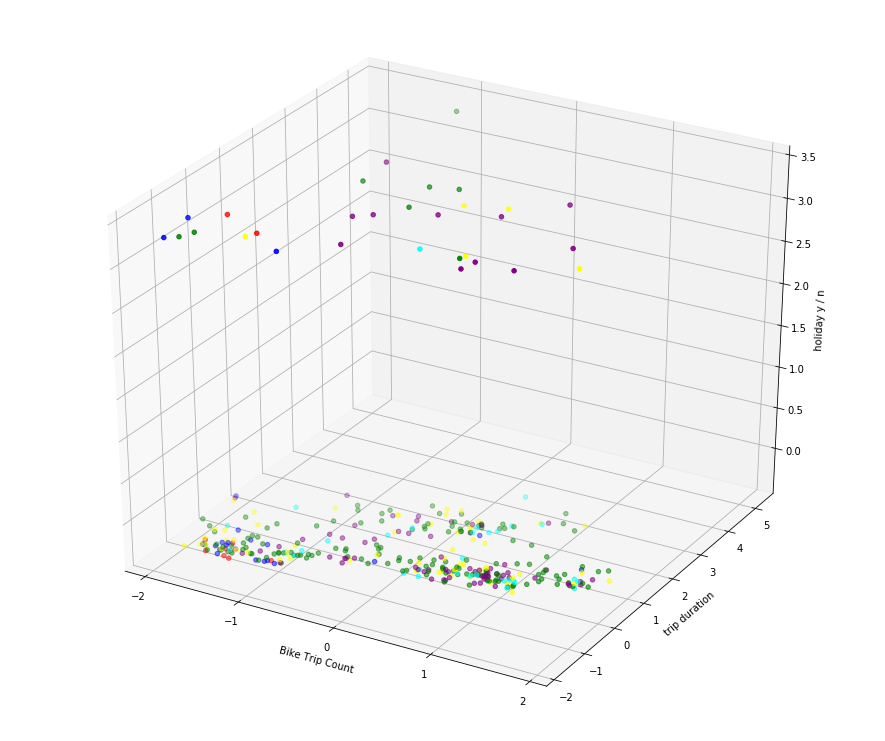

In [37]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.bike_trip_count, X.tripduration, X.holiday, c=citi_df_day_agg.color)
ax.set_xlabel('Bike Trip Count')
ax.set_ylabel('trip duration')
ax.set_zlabel('holiday y / n')
# set x ticks and labels
ax.set_xticks(range(-2, 3, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Isolation Anomaly Detection

### Isolation Forest Anomaly Detection

In [38]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [39]:
citi_df_day_agg_w_z_scores['decision_function'] = clf.decision_function(X)

In [40]:
citi_df_day_agg_w_z_scores.sort_values(by='decision_function').head(10)

,bike_date,holiday_x,weekend_x,bike_trip_count_x,tripduration_x,cluster,km_score,outlier,color,bike_trip_count_y,tripduration_y,holiday_y,weekend_y,decision_function
186,2015-07-06,0,0,34914,14.691843,4,0.184712,0,green,0.596475,0.070081,-0.298843,-0.630377,-0.168293
179,2015-06-29,0,0,37698,14.889570,4,0.183740,0,green,0.804994,0.134496,-0.298843,-0.630377,-0.154082
321,2015-11-18,0,0,41050,13.416370,4,0.711714,0,green,1.056055,-0.345445,-0.298843,-0.630377,-0.152170
82,2015-03-24,0,0,15999,10.938746,2,0.342785,0,purple,-0.820241,-1.152611,-0.298843,-0.630377,-0.142506
40,2015-02-10,0,0,10246,10.221745,2,0.484570,0,purple,-1.251135,-1.386197,-0.298843,-0.630377,-0.138729
314,2015-11-11,1,0,37303,14.037584,0,1.335947,0,blue,0.775409,-0.143065,3.337076,-0.630377,-0.133882
266,2015-09-24,0,0,52177,16.750043,4,1.327960,0,green,1.889457,0.740605,-0.298843,-0.630377,-0.125840
349,2015-12-16,0,0,35214,12.566110,4,0.867658,0,green,0.618944,-0.622445,-0.298843,-0.630377,-0.125427
45,2015-02-15,1,0,2542,9.134540,0,2.784692,1,red,-1.828157,-1.740388,3.337076,-0.630377,-0.123867
131,2015-05-12,0,0,34945,14.210617,4,0.336242,0,green,0.598797,-0.086694,-0.298843,-0.630377,-0.122899


In [41]:
citi_df_day_agg_w_z_scores_final = citi_df_day_agg_w_z_scores[['bike_date', 'km_score', 'decision_function', 'bike_trip_count_x',\
                          'tripduration_x', 'holiday_x', 'weekend_x', \
                                    'bike_trip_count_y', 'tripduration_y', 'holiday_y', 'weekend_y']]
citi_df_day_agg_w_z_scores_final.head()

,bike_date,km_score,decision_function,bike_trip_count_x,tripduration_x,holiday_x,weekend_x,bike_trip_count_y,tripduration_y,holiday_y,weekend_y
358,2015-12-25,5.019717,-0.096909,12188,30.319905,1,1,-1.105681,5.161421,3.337076,1.582005
45,2015-02-15,2.784692,-0.123867,2542,9.134540,1,0,-1.828157,-1.740388,3.337076,-0.630377
46,2015-02-16,2.606726,-0.023027,3930,9.587277,1,0,-1.724198,-1.592895,3.337076,-0.630377
220,2015-08-09,2.508555,0.061464,32395,22.888563,0,0,0.407804,2.740424,-0.298843,-0.630377
1,2015-01-02,2.429584,0.060639,11183,11.813467,1,1,-1.180955,-0.867642,3.337076,1.582005


In [42]:
citi_df_day_agg_w_z_scores_final.sort_values("km_score",ascending=False, inplace=True)
citi_df_day_agg_w_z_scores_final.to_csv('citi_clustered_by_day_w_z_scores.csv')

## Look at specific areas and see what times / dates around there are anomalies
### Madison Square Gardens (40.750556, -73.993611)

In [43]:
latlon_list = [40.750556, -73.993611]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
citi_df_total_subset = citi_df_all_day_agg[(citi_df_all_day_agg['start station latitude'] > (latlon_list[0] - 0.005)) & (citi_df_all_day_agg['start station latitude'] < (latlon_list[0] + 0.005))]
citi_df_total_subset = citi_df_total_subset[(citi_df_total_subset['start station longitude'] > (latlon_list[1] - 0.005)) & (citi_df_total_subset['start station longitude'] < (latlon_list[1] + 0.005))]

In [44]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(citi_df_total_subset['start station longitude'], citi_df_total_subset['start station latitude'])]

In [45]:
crs = {'init': 'epsg:4326'}
citi_df_total_subset = GeoDataFrame(citi_df_total_subset, crs=crs, geometry=geometry)

In [46]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [47]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-73.98861100000001 40.750556, -73.98..."


In [48]:
# only keep points within MSG buffer
citi_df_total_subset = citi_df_total_subset[citi_df_total_subset.geometry.intersects(MSG_gp.geometry[0])]

In [49]:
#take the mean of the taxi stats each day / hour
citi_df_MSG_mean = citi_df_total_subset.groupby(['bike_date'], as_index=False).mean()
citi_df_MSG_mean.head()

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration
0,2015-01-01,1.0,0.0,481.625,40.750011,-73.994025,22.500,13.264523
1,2015-01-02,1.0,1.0,481.625,40.750011,-73.994025,66.125,10.106404
2,2015-01-03,0.0,1.0,481.625,40.750011,-73.994025,19.625,9.091219
3,2015-01-04,0.0,0.0,481.625,40.750011,-73.994025,34.125,9.358956
4,2015-01-05,0.0,0.0,481.625,40.750011,-73.994025,136.125,9.178132


In [50]:
citi_df_MSG_mean['day_of_week'] = citi_df_MSG_mean.bike_date.apply(lambda x: x.weekday())

In [51]:
# read in NYC street shapefile
'''
shapefile taken from https://geo.nyu.edu/catalog/nyu_2451_34565

'''
ny_streets_raw = gp.read_file(proj_folder + '/data/nyu_2451_34565.shp')
ny_streets_raw = ny_streets_raw.to_crs(epsg=4326)
# only keep points within MSG buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

In [52]:
citi_df_total_subset

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration,geometry
158,2015-01-01,1,0,379.0,40.749156,-73.991600,15,16.266667,POINT (-73.99160000000001 40.749156)
216,2015-01-01,1,0,442.0,40.746647,-73.993915,19,12.368421,POINT (-73.993915 40.746647)
262,2015-01-01,1,0,490.0,40.751551,-73.993934,27,12.592593,POINT (-73.993934 40.751551)
264,2015-01-01,1,0,492.0,40.750200,-73.990931,19,9.000000,POINT (-73.99093085 40.75019995)
266,2015-01-01,1,0,494.0,40.747348,-73.997236,19,6.947368,POINT (-73.99723551 40.74734825)
283,2015-01-01,1,0,512.0,40.750073,-73.998393,19,10.052632,POINT (-73.99839279 40.7500727)
292,2015-01-01,1,0,521.0,40.750450,-73.994811,41,12.317073,POINT (-73.99481050999999 40.75044999)
294,2015-01-01,1,0,523.0,40.754666,-73.991382,21,26.571429,POINT (-73.99138152 40.75466591)
485,2015-01-02,1,1,379.0,40.749156,-73.991600,65,8.553846,POINT (-73.99160000000001 40.749156)
542,2015-01-02,1,1,442.0,40.746647,-73.993915,71,10.901408,POINT (-73.993915 40.746647)


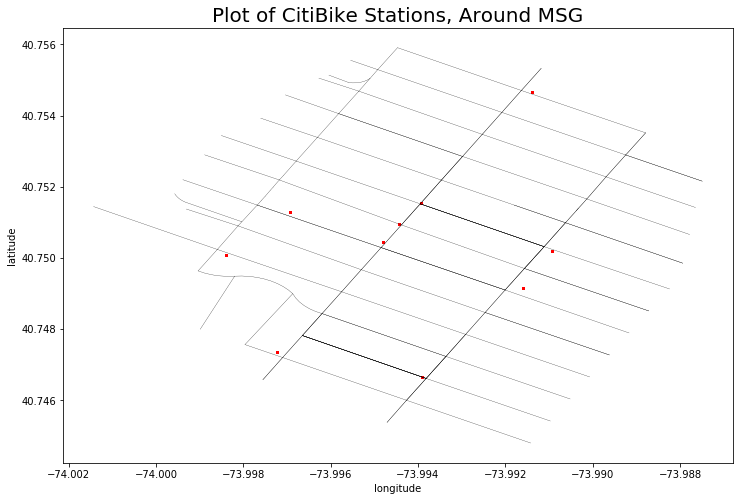

In [53]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = citi_df_total_subset.sample(n=1000)
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of CitiBike Stations, Around MSG", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## MSG anomaly analysis (isolation forest)

In [65]:
citi_df_day_mean_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['tripduration'].mean()
citi_df_count_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['bike_trip_count'].sum()
citi_df_agg_subset = citi_df_count_subset.merge(citi_df_day_mean_subset)
citi_df_agg_subset.head()

,bike_date,holiday,weekend,bike_trip_count,tripduration
0,2015-01-01,1,0,180,13.264523
1,2015-01-02,1,1,529,10.106404
2,2015-01-03,0,1,157,9.091219
3,2015-01-04,0,0,273,9.358956
4,2015-01-05,0,0,1089,9.178132


In [62]:
X = citi_df_agg_subset[cluster_features]
X.head(2)

,bike_trip_count,tripduration,holiday,weekend
0,180,13.264523,1,0
1,529,10.106404,1,1


In [81]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

In [83]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [84]:
citi_df_agg_subset['decision_function'] = clf.decision_function(X)

In [85]:
citi_df_agg_subset.sort_values(by='decision_function').head(10)

,bike_date,holiday,weekend,bike_trip_count,tripduration,decision_function,cluster,km_score,outlier,color
32,2015-02-02,0,0,79,16.155464,-0.175251,1,629.930723,1,red
266,2015-09-24,0,0,2533,14.089123,-0.159496,0,552.749075,0,blue
214,2015-08-03,0,0,2041,11.515498,-0.125911,0,60.755621,0,blue
110,2015-04-21,0,0,1362,12.202905,-0.118764,0,618.253284,1,red
86,2015-03-28,0,1,37,8.776389,-0.112641,1,671.936291,1,red
267,2015-09-25,0,1,1989,16.428117,-0.110815,0,9.610499,0,blue
135,2015-05-16,0,1,694,13.610602,-0.110583,1,14.949650,0,cyan
278,2015-10-06,0,0,2364,14.339617,-0.109566,0,383.751162,0,blue
17,2015-01-18,1,0,77,9.128508,-0.107293,1,631.935286,1,red
63,2015-03-05,0,0,116,10.080659,-0.100393,1,592.930000,0,cyan


### K-Means Cluster Model Anomaly Detection

In [86]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.385579797062
For n_clusters =3, the average silhouette_score is :0.453300514137
For n_clusters =4, the average silhouette_score is :0.453225660689
For n_clusters =5, the average silhouette_score is :0.491668167455
For n_clusters =6, the average silhouette_score is :0.511502412119
For n_clusters =7, the average silhouette_score is :0.557191571685
For n_clusters =8, the average silhouette_score is :0.573718467382


In [87]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [88]:
citi_df_agg_subset['cluster'] = res.cluster
citi_df_agg_subset['km_score'] = res.score
citi_df_agg_subset['outlier'] = 0
citi_df_agg_subset.sort_values("km_score",ascending=False, inplace=True)

In [89]:
citi_df_agg_subset['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [90]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    elif (Data1.cluster == 2):
        return "pink"
    elif (Data1.cluster == 3):
        return "yellow"
    else:
        return "green"

citi_df_agg_subset = citi_df_agg_subset.assign(color=citi_df_agg_subset.apply(set_color, axis=1))

In [91]:
X.sort_values("tripduration",ascending=False, inplace=True)

In [92]:
citi_df_total_subset_w_z_scores = citi_df_agg_subset.merge(X, left_index=True, right_index=True)
z_score = citi_df_total_subset_w_z_scores[['bike_date', 'km_score',  'tripduration_x',\
                          'bike_trip_count_x', 'holiday_x', 'weekend_x', \
                                    'tripduration_x', 'bike_trip_count_x', 'holiday_y', 'weekend_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('citi_MSG_clustered_by_day_w_z_scores.csv')

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


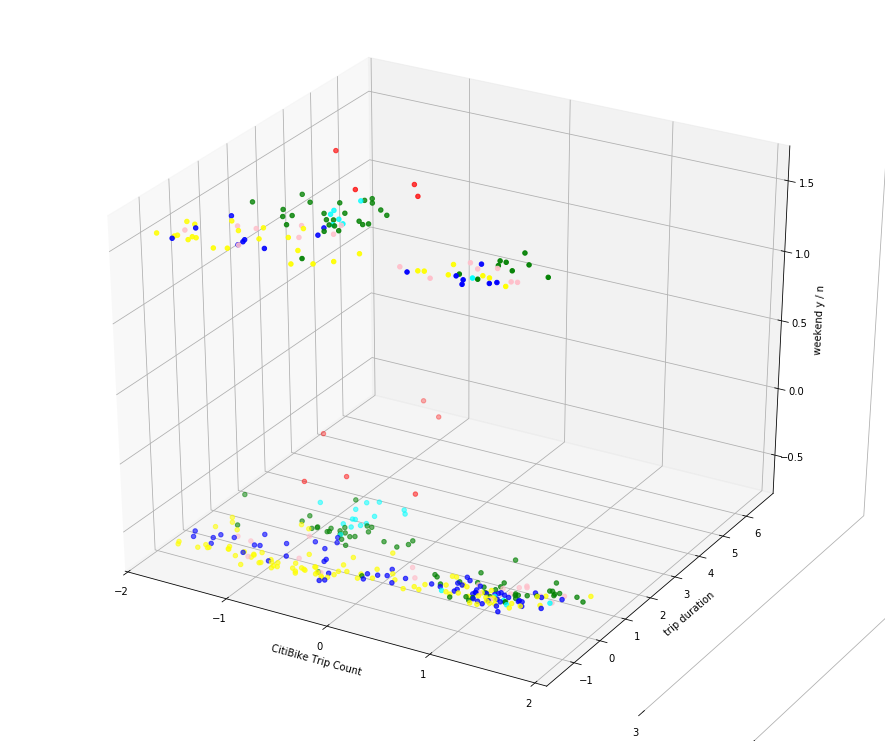

In [93]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.bike_trip_count, X.tripduration, X.weekend, c=citi_df_agg_subset.color)
ax.set_xlabel('CitiBike Trip Count')
ax.set_ylabel('trip duration')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-2, 5, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Look at specific areas and see what times / dates around there are anomalies
### staten island ferry terminal (Whitehall between state & FDR) (40.702095, -74.012782)

In [169]:
latlon_list = [40.702095, -74.012782]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
citi_df_total_subset = citi_df_all_day_agg[(citi_df_all_day_agg['start station latitude'] > (latlon_list[0] - 0.005)) & (citi_df_all_day_agg['start station latitude'] < (latlon_list[0] + 0.005))]
citi_df_total_subset = citi_df_total_subset[(citi_df_total_subset['start station longitude'] > (latlon_list[1] - 0.005)) & (citi_df_total_subset['start station longitude'] < (latlon_list[1] + 0.005))]

In [170]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(citi_df_total_subset['start station longitude'], citi_df_total_subset['start station latitude'])]

In [171]:
crs = {'init': 'epsg:4326'}
citi_df_total_subset = GeoDataFrame(citi_df_total_subset, crs=crs, geometry=geometry)

In [172]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [173]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-74.00778200000001 40.702095, -74.00..."


In [174]:
# only keep points within MSG buffer
citi_df_total_subset = citi_df_total_subset[citi_df_total_subset.geometry.intersects(MSG_gp.geometry[0])]

In [175]:
#take the mean of the taxi stats each day / hour
citi_df_MSG_mean = citi_df_total_subset.groupby(['bike_date'], as_index=False).mean()
citi_df_MSG_mean.head()

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration
0,2015-01-01,1.0,0.0,362.285714,40.703212,-74.011707,6.428571,16.319625
1,2015-01-02,1.0,1.0,362.285714,40.703212,-74.011707,17.000000,14.835784
2,2015-01-03,0.0,1.0,362.285714,40.703212,-74.011707,3.714286,12.814286
3,2015-01-04,0.0,0.0,362.285714,40.703212,-74.011707,7.142857,17.580612
4,2015-01-05,0.0,0.0,362.285714,40.703212,-74.011707,26.285714,13.126105


In [176]:
citi_df_MSG_mean['day_of_week'] = citi_df_MSG_mean.bike_date.apply(lambda x: x.weekday())

In [177]:
# read in NYC street shapefile
'''
shapefile taken from https://geo.nyu.edu/catalog/nyu_2451_34565

'''
ny_streets_raw = gp.read_file(proj_folder + '/data/nyu_2451_34565.shp')
ny_streets_raw = ny_streets_raw.to_crs(epsg=4326)
# only keep points within MSG buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

In [178]:
citi_df_total_subset

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration,geometry
56,2015-01-01,1,0,259.0,40.701221,-74.012342,5,19.200000,POINT (-74.01234218 40.70122128)
57,2015-01-01,1,0,260.0,40.703652,-74.011678,6,19.833333,POINT (-74.01167796999999 40.70365182)
91,2015-01-01,1,0,304.0,40.704633,-74.013617,9,9.888889,POINT (-74.01361706 40.70463334)
122,2015-01-01,1,0,337.0,40.703799,-74.008387,5,24.800000,POINT (-74.00838675999999 40.70379920000001)
192,2015-01-01,1,0,415.0,40.704718,-74.009260,11,8.181818,POINT (-74.00926027 40.7047177)
202,2015-01-01,1,0,427.0,40.701907,-74.013942,6,15.666667,POINT (-74.013942 40.701907)
305,2015-01-01,1,0,534.0,40.702551,-74.012723,3,16.666667,POINT (-74.0127234 40.70255065)
383,2015-01-02,1,1,259.0,40.701221,-74.012342,11,18.727273,POINT (-74.01234218 40.70122128)
384,2015-01-02,1,1,260.0,40.703652,-74.011678,9,12.333333,POINT (-74.01167796999999 40.70365182)
418,2015-01-02,1,1,304.0,40.704633,-74.013617,26,18.384615,POINT (-74.01361706 40.70463334)


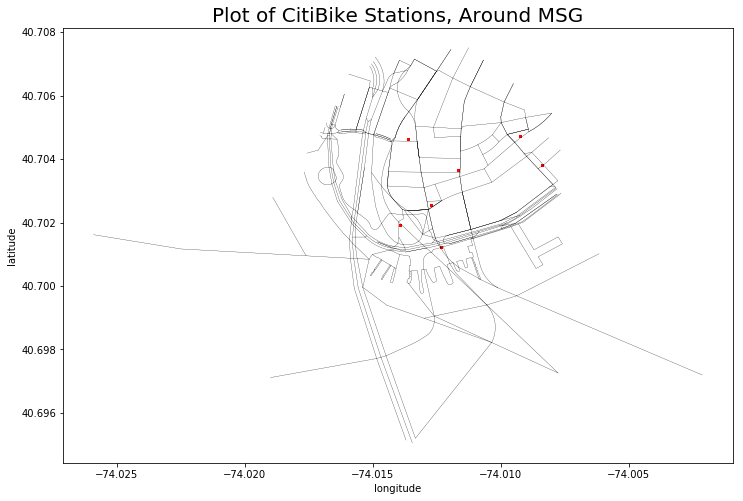

In [179]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = citi_df_total_subset.sample(n=1000)
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of CitiBike Stations, Around MSG", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## MSG anomaly analysis (isolation forest)

In [180]:
citi_df_day_mean_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['tripduration'].mean()
citi_df_count_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['bike_trip_count'].sum()
citi_df_agg_subset = citi_df_count_subset.merge(citi_df_day_mean_subset)
citi_df_agg_subset.head()

,bike_date,holiday,weekend,bike_trip_count,tripduration
0,2015-01-01,1,0,45,16.319625
1,2015-01-02,1,1,119,14.835784
2,2015-01-03,0,1,26,12.814286
3,2015-01-04,0,0,50,17.580612
4,2015-01-05,0,0,184,13.126105


In [181]:
X = citi_df_agg_subset[cluster_features]
X.head(2)

,bike_trip_count,tripduration,holiday,weekend
0,45,16.319625,1,0
1,119,14.835784,1,1


In [182]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [183]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [184]:
citi_df_agg_subset['decision_function'] = clf.decision_function(X)

In [185]:
citi_df_agg_subset.sort_values(by='decision_function').head(10)

,bike_date,holiday,weekend,bike_trip_count,tripduration,decision_function
359,2015-12-26,1,1,148,55.541667,-0.188464
358,2015-12-25,1,1,222,49.450667,-0.174693
330,2015-11-27,1,1,244,35.755417,-0.144704
177,2015-06-27,0,1,156,128.381174,-0.140366
329,2015-11-26,1,0,161,35.450904,-0.126860
184,2015-07-04,1,1,392,27.723986,-0.119189
183,2015-07-03,1,1,439,27.963832,-0.113444
45,2015-02-15,1,0,17,12.171429,-0.113330
46,2015-02-16,1,0,25,11.477891,-0.111573
1,2015-01-02,1,1,119,14.835784,-0.111091


### K-Means Cluster Model Anomaly Detection

In [186]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.402931733569
For n_clusters =3, the average silhouette_score is :0.472397678664
For n_clusters =4, the average silhouette_score is :0.480775146773
For n_clusters =5, the average silhouette_score is :0.492720521247
For n_clusters =6, the average silhouette_score is :0.526068637388
For n_clusters =7, the average silhouette_score is :0.534120162075
For n_clusters =8, the average silhouette_score is :0.46446518648


In [187]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [188]:
citi_df_agg_subset['cluster'] = res.cluster
citi_df_agg_subset['km_score'] = res.score
citi_df_agg_subset['outlier'] = 0
citi_df_agg_subset.sort_values("km_score",ascending=False, inplace=True)

In [189]:
citi_df_agg_subset['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [190]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    elif (Data1.cluster == 2):
        return "pink"
    elif (Data1.cluster == 3):
        return "yellow"
    else:
        return "green"

citi_df_agg_subset = citi_df_agg_subset.assign(color=citi_df_agg_subset.apply(set_color, axis=1))

In [191]:
X.sort_values("tripduration",ascending=False, inplace=True)

In [192]:
citi_df_total_subset_w_z_scores = citi_df_agg_subset.merge(X, left_index=True, right_index=True)
z_score = citi_df_total_subset_w_z_scores[['bike_date', 'km_score',  'tripduration_x',\
                          'bike_trip_count_x', 'holiday_x', 'weekend_x', \
                                    'tripduration_x', 'bike_trip_count_x', 'holiday_y', 'weekend_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('citi_ferry_clustered_by_day_w_z_scores.csv')

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


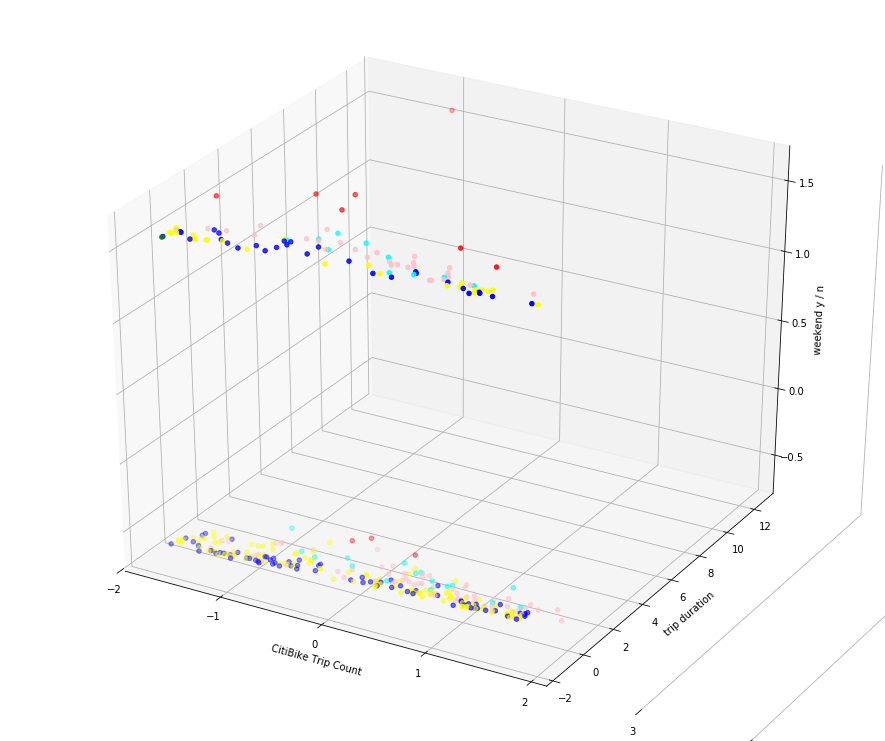

In [193]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.bike_trip_count, X.tripduration, X.weekend, c=citi_df_agg_subset.color)
ax.set_title('Madison Square Gardens / Penn Station CitiBike Clustering')
ax.set_xlabel('CitiBike Trip Count')
ax.set_ylabel('trip duration')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-2, 3, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Look at specific areas and see what times / dates around there are anomalies
### St. Patricks Cathedral (40.758477, -73.976223)

In [246]:
latlon_list = [40.758477, -73.976223]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
citi_df_total_subset = citi_df_all_day_agg[(citi_df_all_day_agg['start station latitude'] > (latlon_list[0] - 0.005)) & (citi_df_all_day_agg['start station latitude'] < (latlon_list[0] + 0.005))]
citi_df_total_subset = citi_df_total_subset[(citi_df_total_subset['start station longitude'] > (latlon_list[1] - 0.005)) & (citi_df_total_subset['start station longitude'] < (latlon_list[1] + 0.005))]

In [247]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(citi_df_total_subset['start station longitude'], citi_df_total_subset['start station latitude'])]

In [248]:
crs = {'init': 'epsg:4326'}
citi_df_total_subset = GeoDataFrame(citi_df_total_subset, crs=crs, geometry=geometry)

In [249]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [250]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-73.97122300000001 40.758477, -73.97..."


In [251]:
# only keep points within MSG buffer
citi_df_total_subset = citi_df_total_subset[citi_df_total_subset.geometry.intersects(MSG_gp.geometry[0])]

In [252]:
#take the mean of the taxi stats each day / hour
citi_df_MSG_mean = citi_df_total_subset.groupby(['bike_date'], as_index=False).mean()
citi_df_MSG_mean.head()

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration
0,2015-01-01,1.0,0.0,434.571429,40.75869,-73.975372,5.142857,20.935714
1,2015-01-02,1.0,1.0,434.571429,40.75869,-73.975372,41.428571,15.530044
2,2015-01-03,0.0,1.0,434.571429,40.75869,-73.975372,3.714286,11.452381
3,2015-01-04,0.0,0.0,434.571429,40.75869,-73.975372,11.000000,11.777778
4,2015-01-05,0.0,0.0,434.571429,40.75869,-73.975372,55.142857,9.340835


In [253]:
citi_df_MSG_mean['day_of_week'] = citi_df_MSG_mean.bike_date.apply(lambda x: x.weekday())

In [254]:
# read in NYC street shapefile
'''
shapefile taken from https://geo.nyu.edu/catalog/nyu_2451_34565

'''
ny_streets_raw = gp.read_file(proj_folder + '/data/nyu_2451_34565.shp')
ny_streets_raw = ny_streets_raw.to_crs(epsg=4326)
# only keep points within MSG buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

In [255]:
citi_df_total_subset

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration,geometry
9,2015-01-01,1,0,137.0,40.761628,-73.972924,4,49.750000,POINT (-73.97292400000001 40.761628)
142,2015-01-01,1,0,359.0,40.755103,-73.974987,2,12.500000,POINT (-73.97498696 40.75510267)
228,2015-01-01,1,0,456.0,40.759711,-73.974023,5,14.600000,POINT (-73.97402311 40.75971079999999)
281,2015-01-01,1,0,510.0,40.760660,-73.980420,3,26.000000,POINT (-73.98042047 40.7606597)
291,2015-01-01,1,0,520.0,40.759923,-73.976485,8,15.500000,POINT (-73.97648516 40.75992262)
293,2015-01-01,1,0,522.0,40.757148,-73.972078,10,16.700000,POINT (-73.97207836 40.75714758)
308,2015-01-01,1,0,538.0,40.756660,-73.976684,4,11.500000,POINT (-73.97668399999999 40.75666)
336,2015-01-02,1,1,137.0,40.761628,-73.972924,28,13.142857,POINT (-73.97292400000001 40.761628)
469,2015-01-02,1,1,359.0,40.755103,-73.974987,60,15.550000,POINT (-73.97498696 40.75510267)
554,2015-01-02,1,1,456.0,40.759711,-73.974023,38,10.868421,POINT (-73.97402311 40.75971079999999)


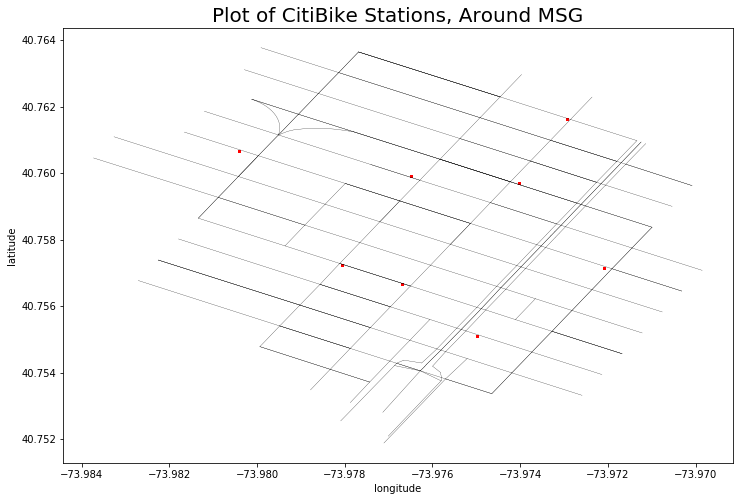

In [256]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = citi_df_total_subset.sample(n=1000)
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of CitiBike Stations, Around MSG", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## MSG anomaly analysis (isolation forest)

In [257]:
citi_df_day_mean_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['tripduration'].mean()
citi_df_count_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['bike_trip_count'].sum()
citi_df_agg_subset = citi_df_count_subset.merge(citi_df_day_mean_subset)
citi_df_agg_subset.head()

,bike_date,holiday,weekend,bike_trip_count,tripduration
0,2015-01-01,1,0,36,20.935714
1,2015-01-02,1,1,290,15.530044
2,2015-01-03,0,1,26,11.452381
3,2015-01-04,0,0,77,11.777778
4,2015-01-05,0,0,386,9.340835


In [258]:
X = citi_df_agg_subset[cluster_features]
X.head(2)

,bike_trip_count,tripduration,holiday,weekend
0,36,20.935714,1,0
1,290,15.530044,1,1


In [271]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

In [272]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [273]:
citi_df_agg_subset['decision_function'] = clf.decision_function(X)

In [274]:
citi_df_agg_subset.sort_values(by='decision_function').head(10)

,bike_date,holiday,weekend,bike_trip_count,tripduration,decision_function,cluster,km_score,outlier,color
292,2015-10-20,0,0,1277,16.424330,-0.146094,0,1.661237,0,blue
309,2015-11-06,0,1,1077,15.686922,-0.131387,2,2.256952,1,red
359,2015-12-26,1,1,218,18.788446,-0.128589,4,1.890550,1,red
344,2015-12-11,0,1,920,12.221984,-0.128069,2,1.720508,0,pink
285,2015-10-13,1,0,952,13.990845,-0.126751,4,1.906701,1,red
169,2015-06-19,0,1,685,13.188041,-0.125066,2,0.914779,0,pink
58,2015-02-28,0,1,56,10.643781,-0.120411,2,1.249935,0,pink
170,2015-06-20,0,1,199,17.214383,-0.119686,2,0.754392,0,pink
63,2015-03-05,0,0,40,17.374603,-0.116625,1,0.872542,0,cyan
301,2015-10-29,0,0,1080,13.322859,-0.115437,0,0.984551,0,blue


### K-Means Cluster Model Anomaly Detection

In [263]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.460288674275
For n_clusters =3, the average silhouette_score is :0.474502227083
For n_clusters =4, the average silhouette_score is :0.567761347693
For n_clusters =5, the average silhouette_score is :0.607757163662
For n_clusters =6, the average silhouette_score is :0.661651736323
For n_clusters =7, the average silhouette_score is :0.662069539086
For n_clusters =8, the average silhouette_score is :0.60424383309


In [275]:
X.head()

,bike_trip_count,tripduration,holiday,weekend
220,-0.571305,18.958326,-0.298843,-0.630377
128,-0.821657,0.598339,-0.298843,1.582005
65,-1.552138,0.494901,-0.298843,1.582005
143,-0.759927,0.322971,3.337076,-0.630377
144,-0.379254,0.273169,3.337076,-0.630377


In [276]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [277]:
citi_df_agg_subset['cluster'] = res.cluster
citi_df_agg_subset['km_score'] = res.score
citi_df_agg_subset['outlier'] = 0
citi_df_agg_subset.sort_values("km_score",ascending=False, inplace=True)

In [278]:
citi_df_agg_subset['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [279]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    elif (Data1.cluster == 2):
        return "pink"
    elif (Data1.cluster == 3):
        return "yellow"
    else:
        return "green"

citi_df_agg_subset = citi_df_agg_subset.assign(color=citi_df_agg_subset.apply(set_color, axis=1))

In [268]:
#X.sort_values("tripduration",ascending=False, inplace=True)

In [280]:
citi_df_total_subset_w_z_scores = citi_df_agg_subset.merge(X, left_index=True, right_index=True)
z_score = citi_df_total_subset_w_z_scores[['bike_date', 'km_score',  'tripduration_x',\
                          'bike_trip_count_x', 'holiday_x', 'weekend_x', \
                                    'tripduration_x', 'bike_trip_count_x', 'holiday_y', 'weekend_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('citi_patrick_clustered_by_day_w_z_scores.csv')

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [282]:
X.head()

,bike_trip_count,tripduration,holiday,weekend
220,-0.571305,18.958326,-0.298843,-0.630377
128,-0.821657,0.598339,-0.298843,1.582005
65,-1.552138,0.494901,-0.298843,1.582005
143,-0.759927,0.322971,3.337076,-0.630377
144,-0.379254,0.273169,3.337076,-0.630377


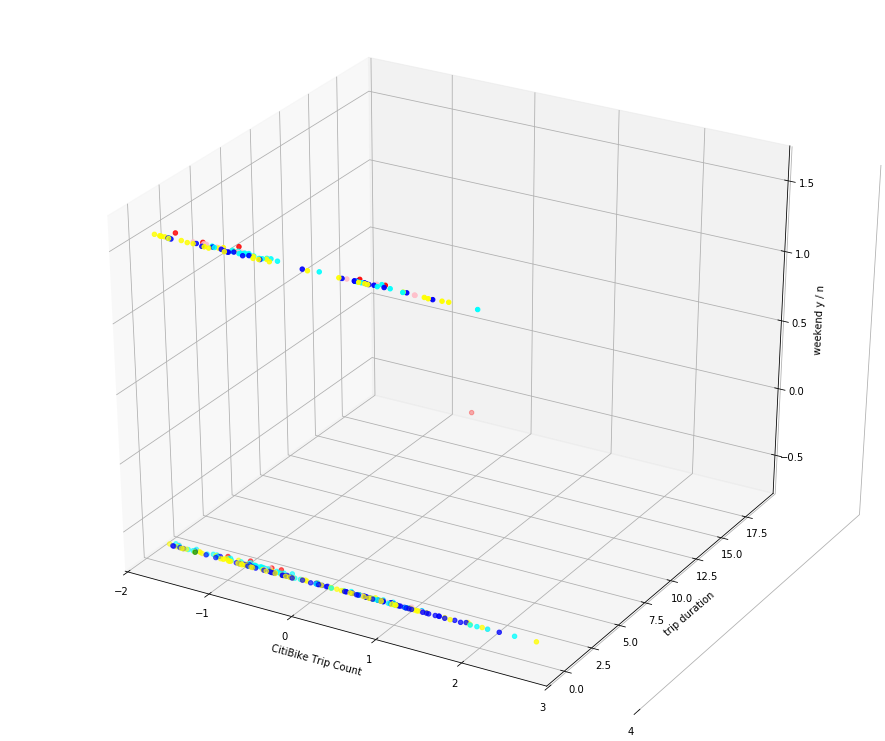

In [281]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.bike_trip_count, X.tripduration, X.weekend, c=citi_df_agg_subset.color)
ax.set_xlabel('CitiBike Trip Count')
ax.set_ylabel('trip duration')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-2, 5, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()

## Look at specific areas and see what times / dates around there are anomalies
### Metropolitan Opera (40.772567, -73.984089)

In [219]:
latlon_list = [40.772567, -73.984089]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
citi_df_total_subset = citi_df_all_day_agg[(citi_df_all_day_agg['start station latitude'] > (latlon_list[0] - 0.005)) & (citi_df_all_day_agg['start station latitude'] < (latlon_list[0] + 0.005))]
citi_df_total_subset = citi_df_total_subset[(citi_df_total_subset['start station longitude'] > (latlon_list[1] - 0.005)) & (citi_df_total_subset['start station longitude'] < (latlon_list[1] + 0.005))]

In [220]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(citi_df_total_subset['start station longitude'], citi_df_total_subset['start station latitude'])]

In [221]:
crs = {'init': 'epsg:4326'}
citi_df_total_subset = GeoDataFrame(citi_df_total_subset, crs=crs, geometry=geometry)

In [222]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [223]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-73.979089 40.772567, -73.9791130763..."


In [224]:
# only keep points within MSG buffer
citi_df_total_subset = citi_df_total_subset[citi_df_total_subset.geometry.intersects(MSG_gp.geometry[0])]

In [225]:
#take the mean of the taxi stats each day / hour
citi_df_MSG_mean = citi_df_total_subset.groupby(['bike_date'], as_index=False).mean()
citi_df_MSG_mean.head()

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration
0,2015-01-01,1.0,0.0,460.5,40.769834,-73.984978,33.5,19.761905
1,2015-01-02,1.0,1.0,460.5,40.769834,-73.984978,44.0,18.256293
2,2015-01-03,0.0,1.0,460.5,40.769834,-73.984978,13.0,8.491667
3,2015-01-04,0.0,0.0,460.5,40.769834,-73.984978,38.5,14.795699
4,2015-01-05,0.0,0.0,460.5,40.769834,-73.984978,47.5,12.467105


In [226]:
citi_df_MSG_mean['day_of_week'] = citi_df_MSG_mean.bike_date.apply(lambda x: x.weekday())

In [227]:
# read in NYC street shapefile
'''
shapefile taken from https://geo.nyu.edu/catalog/nyu_2451_34565

'''
ny_streets_raw = gp.read_file(proj_folder + '/data/nyu_2451_34565.shp')
ny_streets_raw = ny_streets_raw.to_crs(epsg=4326)
# only keep points within MSG buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

In [228]:
citi_df_total_subset

,bike_date,holiday,weekend,start_station_id,start station latitude,start station longitude,bike_trip_count,tripduration,geometry
199,2015-01-01,1,0,422.0,40.770513,-73.988038,4,19.000000,POINT (-73.988038 40.770513)
271,2015-01-01,1,0,499.0,40.769155,-73.981918,63,20.523810,POINT (-73.98191841000001 40.76915505)
526,2015-01-02,1,1,422.0,40.770513,-73.988038,19,21.947368,POINT (-73.988038 40.770513)
597,2015-01-02,1,1,499.0,40.769155,-73.981918,69,14.565217,POINT (-73.98191841000001 40.76915505)
849,2015-01-03,0,1,422.0,40.770513,-73.988038,6,8.333333,POINT (-73.988038 40.770513)
921,2015-01-03,0,1,499.0,40.769155,-73.981918,20,8.650000,POINT (-73.98191841000001 40.76915505)
1177,2015-01-04,0,0,422.0,40.770513,-73.988038,15,12.333333,POINT (-73.988038 40.770513)
1249,2015-01-04,0,0,499.0,40.769155,-73.981918,62,17.258065,POINT (-73.98191841000001 40.76915505)
1506,2015-01-05,0,0,422.0,40.770513,-73.988038,19,13.736842,POINT (-73.988038 40.770513)
1578,2015-01-05,0,0,499.0,40.769155,-73.981918,76,11.197368,POINT (-73.98191841000001 40.76915505)


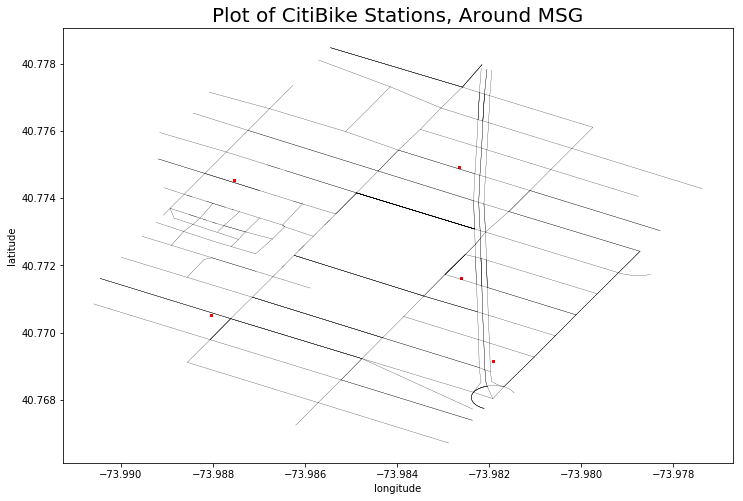

In [229]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = citi_df_total_subset.sample(n=1000)
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of CitiBike Stations, Around MSG", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## MSG anomaly analysis (isolation forest)

In [230]:
citi_df_day_mean_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['tripduration'].mean()
citi_df_count_subset = citi_df_total_subset.groupby(['bike_date', 'holiday', 'weekend'], as_index=False)['bike_trip_count'].sum()
citi_df_agg_subset = citi_df_count_subset.merge(citi_df_day_mean_subset)
citi_df_agg_subset.head()

,bike_date,holiday,weekend,bike_trip_count,tripduration
0,2015-01-01,1,0,67,19.761905
1,2015-01-02,1,1,88,18.256293
2,2015-01-03,0,1,26,8.491667
3,2015-01-04,0,0,77,14.795699
4,2015-01-05,0,0,95,12.467105


In [231]:
X = citi_df_agg_subset[cluster_features]
X.head(2)

,bike_trip_count,tripduration,holiday,weekend
0,67,19.761905,1,0
1,88,18.256293,1,1


In [232]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [233]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [234]:
citi_df_agg_subset['decision_function'] = clf.decision_function(X)

In [235]:
citi_df_agg_subset.sort_values(by='decision_function').head(10)

,bike_date,holiday,weekend,bike_trip_count,tripduration,decision_function
358,2015-12-25,1,1,184,58.510383,-0.191635
45,2015-02-15,1,0,15,31.576923,-0.160337
184,2015-07-04,1,1,271,33.820462,-0.159566
359,2015-12-26,1,1,208,12.556397,-0.134519
183,2015-07-03,1,1,393,29.226111,-0.130098
1,2015-01-02,1,1,88,18.256293,-0.125706
144,2015-05-25,1,0,438,32.014662,-0.116187
283,2015-10-11,1,0,643,24.323917,-0.115634
28,2015-01-29,0,0,52,51.082040,-0.114630
284,2015-10-12,1,0,634,22.731761,-0.112073


### K-Means Cluster Model Anomaly Detection

In [236]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.372252788314
For n_clusters =3, the average silhouette_score is :0.435099238096
For n_clusters =4, the average silhouette_score is :0.415089043215
For n_clusters =5, the average silhouette_score is :0.452627084082
For n_clusters =6, the average silhouette_score is :0.445323836595
For n_clusters =7, the average silhouette_score is :0.457784646768
For n_clusters =8, the average silhouette_score is :0.468356028888


In [237]:
n=5
KM=KMeans(n_clusters=n,random_state=999)
scor=KM.fit_predict(X)

res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(n))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

In [238]:
citi_df_agg_subset['cluster'] = res.cluster
citi_df_agg_subset['km_score'] = res.score
citi_df_agg_subset['outlier'] = 0
citi_df_agg_subset.sort_values("km_score",ascending=False, inplace=True)

In [239]:
citi_df_agg_subset['outlier'][:10] = 1 

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [240]:
def set_color(Data1):
    if (Data1.outlier == 1):
        return "red"
    elif (Data1.cluster == 0):
        return "blue"
    elif (Data1.cluster == 1):
        return "cyan"
    elif (Data1.cluster == 2):
        return "pink"
    elif (Data1.cluster == 3):
        return "yellow"
    else:
        return "green"

citi_df_agg_subset = citi_df_agg_subset.assign(color=citi_df_agg_subset.apply(set_color, axis=1))

In [241]:
X.sort_values("tripduration",ascending=False, inplace=True)

In [242]:
citi_df_total_subset_w_z_scores = citi_df_agg_subset.merge(X, left_index=True, right_index=True)
z_score = citi_df_total_subset_w_z_scores[['bike_date', 'km_score',  'tripduration_x',\
                          'bike_trip_count_x', 'holiday_x', 'weekend_x', \
                                    'tripduration_x', 'bike_trip_count_x', 'holiday_y', 'weekend_y']]
z_score.sort_values("km_score",ascending=False, inplace=True)
z_score.to_csv('citi_met_clustered_by_day_w_z_scores.csv')

/gpfs1/cusp/gtp232/.conda/envs/GTP/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


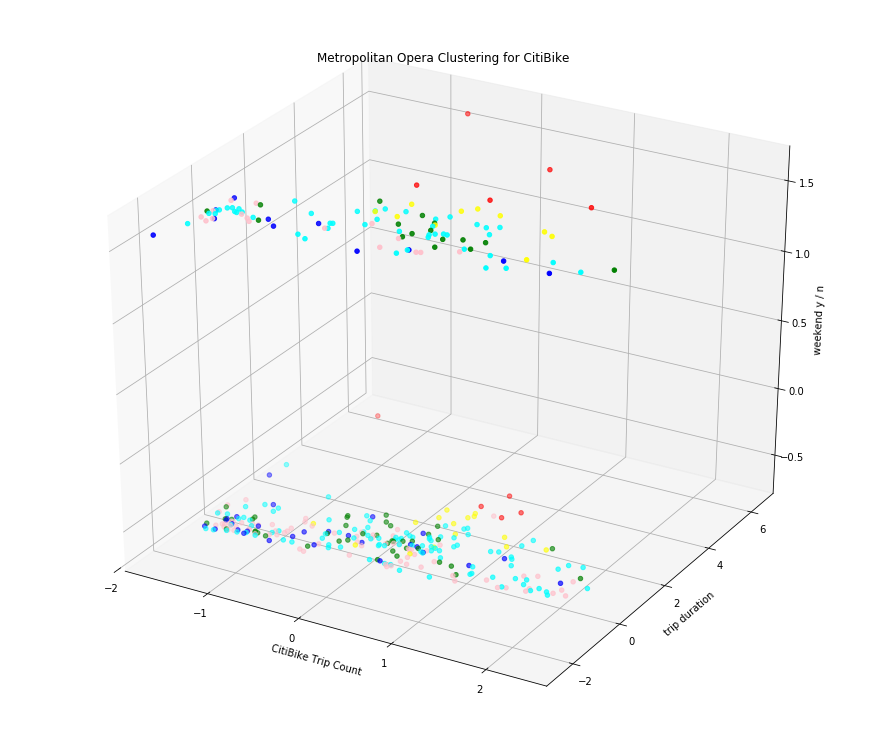

In [245]:
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

ax.scatter(X.bike_trip_count, X.tripduration, X.weekend, c=citi_df_agg_subset.color)
ax.set_title('Metropolitan Opera Clustering for CitiBike')
ax.set_xlabel('CitiBike Trip Count')
ax.set_ylabel('trip duration')
ax.set_zlabel('weekend y / n')
# set x ticks and labels
ax.set_xticks(range(-2, 3, 1))
# change fontsize
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
plt.show()